In [1]:
import time
import torch
import numpy as np
import networkx as nx
import collections
import matplotlib.pyplot as plt
from data.gene_graphs import GeneManiaGraph, RegNetGraph
from scipy import sparse
import joblib 
import sklearn.cluster
import scipy.cluster
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import ward, fcluster
from sklearn.cluster import AgglomerativeClustering
#torch.cuda.set_device(1)

In [2]:

def show_degree(G):  
    degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
    # print "Degree sequence", degree_sequence
    degreeCount = collections.Counter(degree_sequence)
    deg, cnt = zip(*degreeCount.items())

    fig, ax = plt.subplots()
    plt.bar(deg, cnt, width=0.80, color='b')

    plt.title("Degree Histogram")
    plt.ylabel("Count")
    plt.xlabel("Degree")
    ax.set_xticks([d + 0.4 for d in deg])
    ax.set_xticklabels(deg)

    # draw graph in inset
    plt.axes([0.4, 0.4, 0.5, 0.5])
    Gcc = sorted(nx.connected_component_subgraphs(G), key=len, reverse=True)[0]
    pos = nx.spring_layout(G)
    plt.axis('off')
    nx.draw_networkx_nodes(G, pos, node_size=20)
    nx.draw_networkx_edges(G, pos, alpha=0.4)

    plt.show()


In [3]:
rand = torch.rand(10,10)
symmetric = torch.mm(rand, rand.t()) # make symmetric positive definite
adj = torch.ByteTensor(symmetric>symmetric.mean())


In [4]:
print(adj)

tensor([[1, 0, 0, 0, 0, 1, 0, 0, 0, 1],
        [0, 1, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 1, 0, 0, 1, 1],
        [0, 1, 0, 1, 0, 1, 0, 0, 1, 1],
        [0, 0, 0, 0, 1, 1, 0, 0, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1]], dtype=torch.uint8)


In [5]:
gene_graph = GeneManiaGraph()
adj = np.array(nx.to_numpy_matrix(gene_graph.nx_graph))

Torrent name: genemania.pkl, Size: 9.61MB


In [8]:
clusters = AgglomerativeClustering(n_clusters=4, affinity='euclidean', memory='.cache', connectivity=(adj > 0.).astype(bool), compute_full_tree='auto', linkage='ward').fit_predict(adj)
print(clusters)


[2 1 1 2 0 0 0 3 3 0]


/Users/martinweiss/code/academic/conv-graph/venv/lib/python3.5/site-packages/sklearn/cluster/hierarchical.py:244: UserWarning: the number of connected components of the connectivity matrix is 3 > 1. Completing it to avoid stopping the tree early.
  affinity='euclidean')


In [ ]:
new_ids = []
biggest_cluster = np.argmax(np.bincount(clusters))
for i, cluster in enumerate(clusters):
    if cluster != biggest_cluster:
        new_ids.append(i)
new_adj = adj[new_ids, :][:, new_ids]

In [10]:
new_adj

tensor([[1, 0, 0],
        [0, 0, 0],
        [0, 0, 0]], dtype=torch.uint8)

/Users/martinweiss/code/academic/conv-graph/venv/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


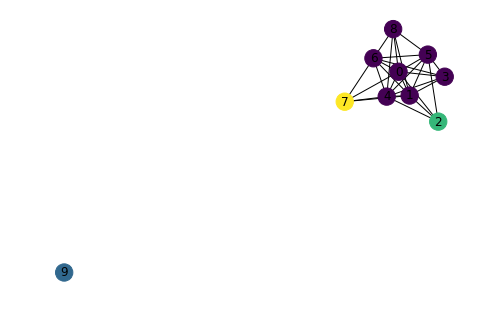

In [11]:
G = nx.from_numpy_matrix(np.matrix(adj)) 
nx.draw(G, node_color=clusters, with_labels=True)

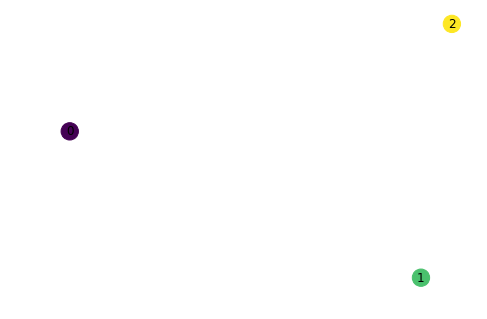

In [12]:
G = nx.from_numpy_matrix(np.matrix(new_adj)) 
nx.draw(G, node_color=new_ids, with_labels=True)

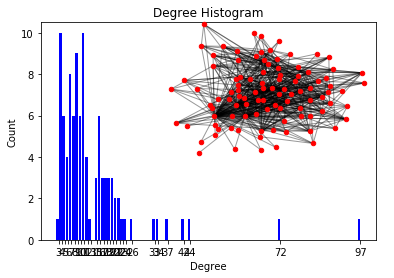

In [98]:
G = nx.from_numpy_matrix(np.matrix(adj))
show_degree(G)

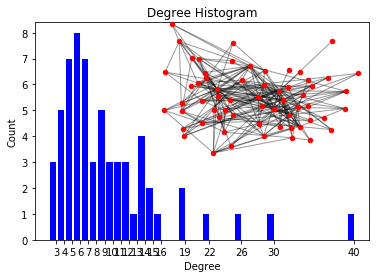

In [96]:
G = nx.from_numpy_matrix(np.matrix(new_adj))
show_degree(G)

In [336]:
## All the edge weights are really small. They are actually confidence intervals. Also, it's a sparse graph

Torrent name: genemania.pkl, Size: 9.61MB


In [11]:
def bucket_weights(adj, bins):
    labels = ["".join(str(labels[0]) + "-" + str(round(labels[1], 1))) for labels in zip(bins, bins + 0.1)]
    labels[0] = "(" + labels[0]

    results = []
    nodes = {}
    for x in bins:
        subgraph = ((adj > x) & (adj <= x + 0.1))  
        results.append(subgraph.sum())
        nodes[x] = subgraph
    return results, labels, nodes

In [113]:
gene_graph = GeneManiaGraph()
genemania_adj = np.asarray(nx.to_numpy_matrix(gene_graph.nx_graph))

Torrent name: genemania.pkl, Size: 9.61MB
Checking for pieces on disk: |██████████████████████████████████████████████████| 100.0% 
Found 294 finished pieces out of 294 total pieces.
Found dataset at /Users/martinweiss/.academictorrents-datastore/genemania.pkl


In [114]:
bins = np.array([round(x, 1) for x in np.arange(0., 1., 0.1)])
genemania_results, genemania_labels, nodes = bucket_weights(genemania_adj, bins)

In [115]:
len(genemania_labels)

10

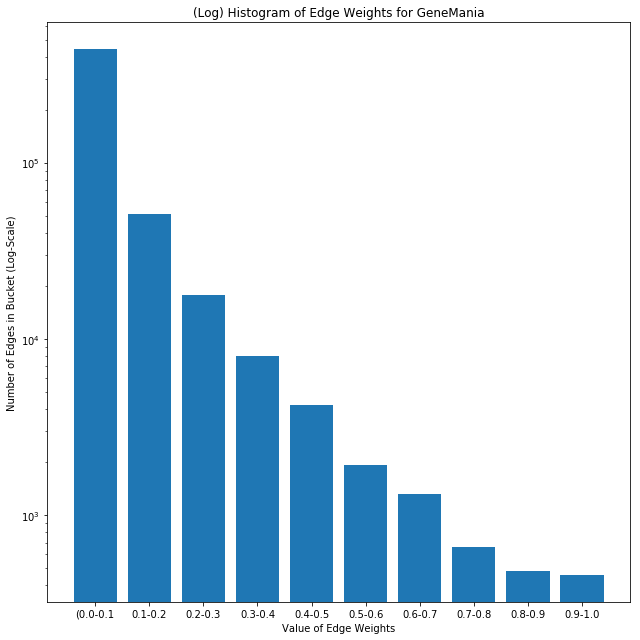

In [116]:
plt.figure(figsize=(9, 9))

plt.bar(x=genemania_labels, height=genemania_results, log=1)
plt.title("(Log) Histogram of Edge Weights for GeneMania")
plt.xlabel("Value of Edge Weights")
plt.ylabel("Number of Edges in Bucket (Log-Scale)")
plt.xlim=1.0

plt.tight_layout()
plt.show()

In [137]:
def bucket_weights_regnet(adj, bins):
    labels = ["".join(str(labels[0]) + "-" + str(round(labels[1], 3))) for labels in zip(bins, bins + 0.005)]
    labels[0] = "(" + labels[0]

    results = []
    nodes = {}
    for x in bins:
        subgraph = ((adj > x) & (adj <= x + 0.1))  
        results.append(subgraph.sum())
        nodes[x] = subgraph
    return results, labels, nodes

In [138]:
regnet = RegNetGraph()
regnet_adj = np.asarray(nx.to_numpy_matrix(regnet.nx_graph))

Torrent name: regnet.pkl, Size: 8.81MB


In [139]:
bins = np.array([round(x, 3) for x in np.arange(0., .056, 0.005)])
regnet_results, regnet_labels, nodes = bucket_weights_regnet(regnet_adj, bins)

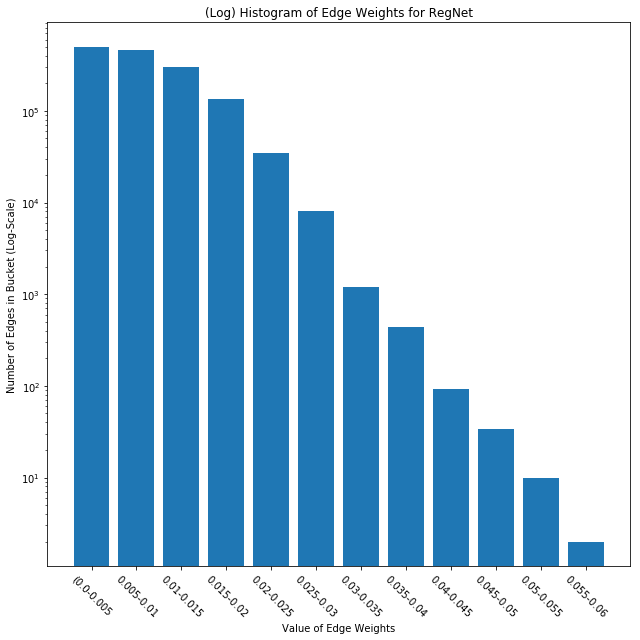

In [142]:
plt.figure(figsize=(9, 9))

plt.bar(x=regnet_labels, height=regnet_results, log=1)
plt.title("(Log) Histogram of Edge Weights for RegNet")
plt.xlabel("Value of Edge Weights")
plt.ylabel("Number of Edges in Bucket (Log-Scale)")
plt.xlim=1.0
plt.xticks(rotation=-45)

plt.tight_layout()
plt.show()

In [7]:
regnet = RegNetGraph()

Torrent name: regnet.pkl, Size: 8.81MB
Checking for pieces on disk: |██████████████████████████████████████████████████| 100.0% 
Found 269 finished pieces out of 269 total pieces.
Found dataset at /Users/martinweiss/.academictorrents-datastore/regnet.pkl


In [8]:
nodes, one_gene_adj = regnet.first_degree("RPL3")
print("num_edges: " + str((one_gene_adj>0.).sum()/2))

num_edges: 1007.0


/Users/martinweiss/code/academic/conv-graph/venv/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


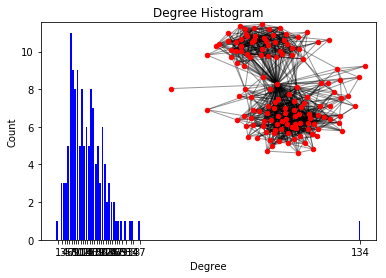

In [9]:
G = nx.from_numpy_matrix(np.matrix(one_gene_adj))
show_degree(G)

In [12]:
temp = np.array(nx.to_numpy_matrix(regnet.nx_graph))/np.array(nx.to_numpy_matrix(regnet.nx_graph)).max()
bins = np.array([round(x, 1) for x in np.arange(0., 1., 0.1)])
regnet_results, regnet_labels, nodes = bucket_weights(temp, bins)

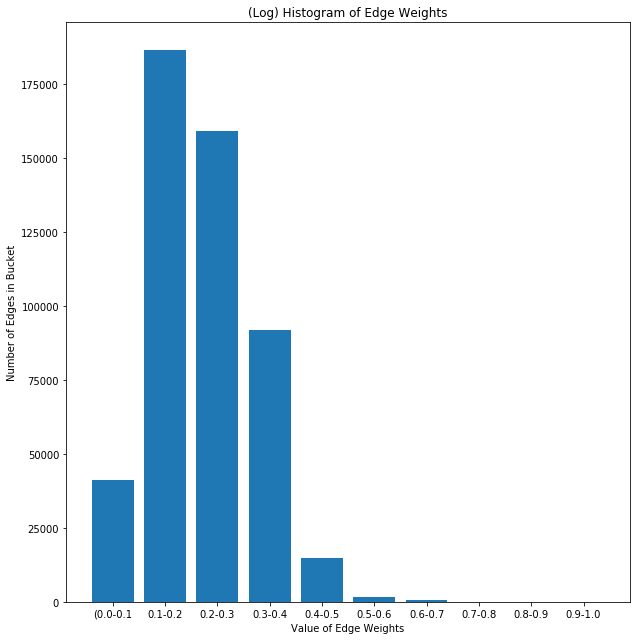

In [13]:
plt.figure(figsize=(9, 9))

plt.bar(x=regnet_labels, height=regnet_results)
plt.title("(Log) Histogram of Edge Weights")
plt.xlabel("Value of Edge Weights")
plt.ylabel("Number of Edges in Bucket")
plt.xlim=1.0

plt.tight_layout()
plt.show()

/Users/martinweiss/code/academic/conv-graph/venv/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


Clustered by SKLearn Agglomerative Clustering


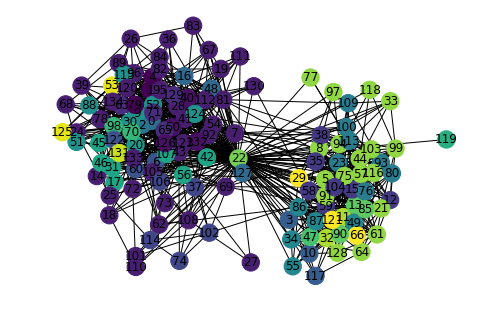

In [14]:
clusters = AgglomerativeClustering(n_clusters=25, affinity='euclidean', memory='/tmp', connectivity=one_gene_adj, compute_full_tree='auto', linkage='ward').fit_predict(one_gene_adj)
G = nx.from_numpy_matrix(np.matrix(one_gene_adj)) 
nx.draw(G, node_color=clusters, with_labels=True)
print("Clustered by SKLearn Agglomerative Clustering")


(array([20., 12.,  4.,  4.,  5.,  4.,  1.,  0.,  0.,  1.]),
 array([ 0.,  4.,  8., 12., 16., 20., 24., 28., 32., 36., 40.]),
 <a list of 10 Patch objects>)

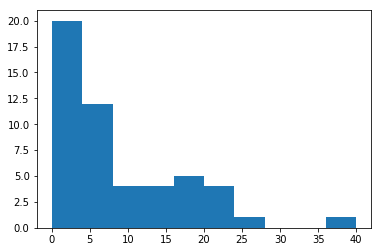

In [25]:
plt.hist(np.hstack(np.histogram(clusters, bins=len(set(clusters)))))

(array([47, 11, 11,  5, 12, 15,  3,  5, 20,  6]),
 array([ 0. ,  2.4,  4.8,  7.2,  9.6, 12. , 14.4, 16.8, 19.2, 21.6, 24. ]))

In [23]:
new_clusters = []
biggest_cluster = np.argmax(np.bincount(clusters))
for i, cluster in enumerate(clusters):
    if cluster != biggest_cluster:
        new_clusters.append(i)


In [ ]:
nodes, one_gene_adj = regnet.first_degree("RPL3")
print("num_edges: " + str((one_gene_adj>0.).sum()/2))

In [25]:
np.max(one_gene_adj[16], axis=0)

0.024000000208616257

In [29]:
np.set_printoptions(threshold=np.nan)


In [32]:
one_gene_adj.shape

(135, 135)

In [73]:
num_genes = np.histogram(one_gene_adj.max(axis=1))[0]
edge_weight =  np.histogram(one_gene_adj.max(axis=1))[1]

([<matplotlib.axis.XTick at 0x10bd3e358>,
 <a list of 10 Text xticklabel objects>)

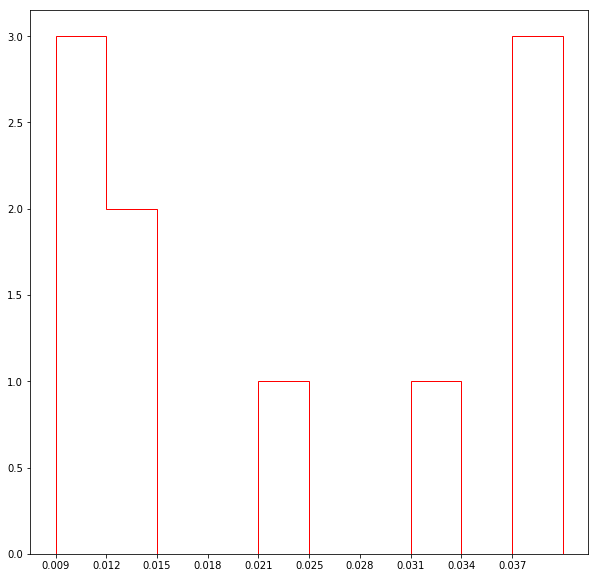

In [110]:
plt.figure(figsize=(10,10))
plt.hist(num_genes, bins=10, range=[0, 30], histtype='step',edgecolor='r')
plt.xticks(range(0, 30, 3), [round(x,3) for x in edge_weight])


<BarContainer object of 10 artists>

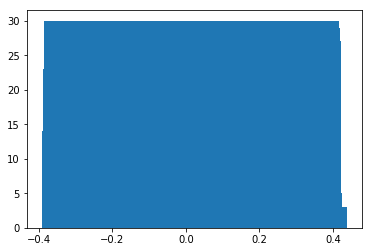

In [85]:
plt.bar(x=edge_weight[:10], height=num_genes)

ValueError: 'c' argument has 7220 elements, which is not acceptable for use with 'x' with size 135, 'y' with size 135.

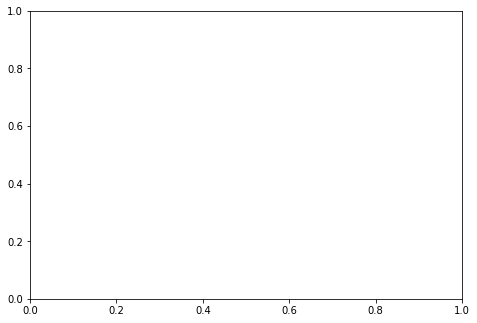

In [27]:
max_edge_weight = {}
i=0
for b in bins:
    for node1, node2 in np.argwhere(nodes[b]):
        max_edge_weight[node1] = int(10 * b)
        max_edge_weight[node2] = int(10 * b)
edge_colors = list((np.round(one_gene_adj[one_gene_adj.nonzero()].flatten(), 1) * 10).astype(int))[::2]
nx.draw(G, node_color=list(max_edge_weight.values()), edge_color=edge_colors, with_labels=True)
print("Clustered by max edge weight")


# Make the chart
bins = np.array([round(x, 1) for x in np.arange(0., 1., 0.1)])
one_gene_results, one_gene_labels, nodes = bucket_weights(one_gene_adj, bins)
plt.figure(figsize=(9, 9))
plt.bar(x=one_gene_labels, height=one_gene_results)
plt.title("Histogram of Edge Weights for a BFS Resulting in 50 genes near TERT")
plt.xlabel("Value of Edge Weight")
plt.ylabel("Number of Edges in Bucket")
plt.xticks(bins*10, labels=one_gene_labels[1:])
plt.show()

In [ ]:
fcluster

[5 0 0 3 2 2 4 1 1 2]


/Users/martinweiss/code/academic/conv-graph/venv/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


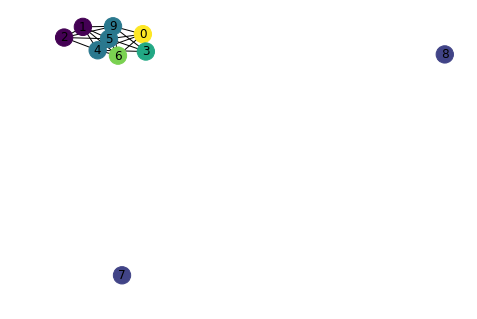

In [28]:
mirror = 1 - adj
clusters = AgglomerativeClustering(n_clusters=6, affinity='euclidean', memory='/tmp', connectivity=adj > 0., compute_full_tree='auto', linkage='ward').fit_predict(mirror)
print(clusters)
G = nx.from_numpy_matrix(np.matrix(adj)) 
nx.draw(G, node_color=clusters, with_labels=True)

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage


Z = linkage(genemania_adj)

dendrogram(Z)  


/Users/martinweiss/code/academic/conv-graph/venv/lib/python3.5/site-packages/ipykernel_launcher.py:4: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  after removing the cwd from sys.path.


In [ ]:
clusters = AgglomerativeClustering(n_clusters=25, affinity='euclidean', memory='/tmp', connectivity=adj > 0., compute_full_tree='auto', linkage='ward').fit_predict(adj > 0.)
print(clusters)
G = nx.from_numpy_matrix(np.matrix(adj)) 
nx.draw_spring(G, node_color=clusters, with_labels=True)

In [ ]:
clusters

In [410]:
"PTP4A1', 'KLHL25', 'MTFMT', 'CRYGS', 'ITGAX', 'UMOD', 'MAPK9', 'ZNF382', 'BBS9', 'SLC41A1', 'LGALS2', 'TRMT44', 'FAM219A', 'CPSF3L', 'SH2D2A', 'TTC33', 'HSD11B1', 'CLEC12A', 'TUSC1', 'CD99L2', 'FAM105A', 'VASN', 'PSMD3', 'C1orf216"

"PTP4A1', 'KLHL25', 'MTFMT', 'CRYGS', 'ITGAX', 'UMOD', 'MAPK9', 'ZNF382', 'BBS9', 'SLC41A1', 'LGALS2', 'TRMT44', 'FAM219A', 'CPSF3L', 'SH2D2A', 'TTC33', 'HSD11B1', 'CLEC12A', 'TUSC1', 'CD99L2', 'FAM105A', 'VASN', 'PSMD3', 'C1orf216"

In [375]:
dist_adj = pdist(adj)

In [376]:
dist_adj

array([0.35910108, 0.30082571, 0.31920731, ..., 0.33999554, 0.34134374,
       0.20770223])

In [10]:
adj

tensor([[1, 0, 0, 1, 1, 1, 1, 0, 0, 1],
        [0, 1, 1, 0, 1, 1, 1, 0, 0, 1],
        [0, 1, 1, 0, 1, 1, 0, 0, 0, 1],
        [1, 0, 0, 1, 1, 1, 0, 0, 0, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 0, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 0, 1],
        [1, 1, 0, 0, 1, 1, 1, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 0, 0, 1]], dtype=torch.uint8)

In [11]:
linkage = scipy.cluster.hierarchy.linkage(dist_adj)


NameError: name 'dist_adj' is not defined

In [362]:
z = ward(linkage)

In [363]:
cluster = fcluster(z, 18, criterion='distance')


In [143]:
len(set(cluster))


49

In [148]:
cluster

99

ValueError: 'c' argument has 99 elements, which is not acceptable for use with 'x' with size 100, 'y' with size 100.

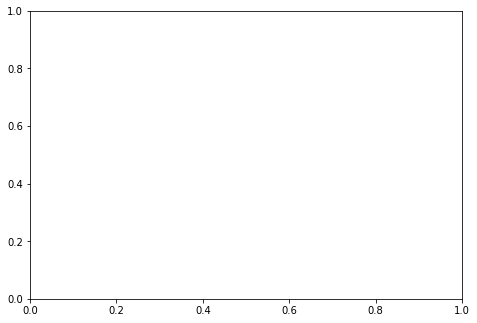

In [147]:
G = nx.from_numpy_matrix(np.matrix(adj)) 
nx.draw_shell(G, node_color=cluster.tolist(), with_labels=True)
